# Quantifying semisc similarity
## Chapter X: Data sequence analysis patches 

### Author: Anders Kampenes

### Dimension reduction and visualization with PCA

In [1]:
### Loading and preparing dataset

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.colors as colors

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image,  plot_random_directions, plot_subset_of_directions 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch,blockshaped, unblockshaped, plot_embeddings, plot_patched_directions, create_patched_data


#load  seimsic data
chapterName = "visualizing-seismic-using-a-variational-autoencoder"
output_folder = "/home/andykamp/master/quantify_seismic_similarity/notebooks/" + chapterName


In [6]:

#load  seimsic data
data_cube = np.load("/home/andykamp/master/quantify_seismic_similarity/data/processed/f3_entire_int8.npy")


print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])

img shape (651, 951, 462)
651 951 462


21


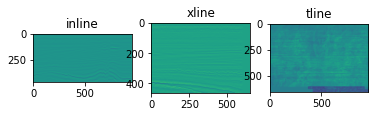

In [7]:


# plt different slices 
plot_random_directions(data, 100)

   

In [8]:
"""
We see that inline and xline directions have clear stacking patterns, 
but the tline is more meshy.

Intuitivly, we would could easily see more clear pattern change in iline/xline direction 
"""

'\nWe see that inline and xline directions have clear stacking patterns, \nbut the tline is more meshy.\n\nIntuitivly, we would could easily see more clear pattern change in iline/xline direction \n'

In [9]:
# but beforre we can do this we need to pad the images to go up in the wanted patch size
patch_size = 64

padding_needed {'inline': 53, 'xline': 9, 'tline': 50}
Found inline
Found xline
Found tline
padded_data (704, 960, 512)
padded_data (960, 704, 512)
padded_data (512, 960, 704)


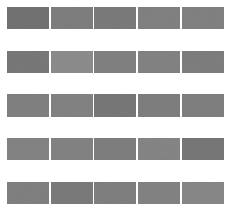

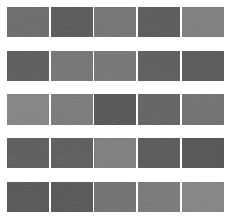

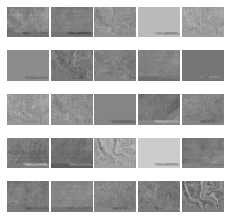

In [10]:
## We then pad each direction to be able to grid it to a 16, 32, 64 ++ grid. 
# The reason we choose such numbers are gupu optimilization (LINK)



padded_data = pad_data_to_fit_patch(data, patch_size, directions, num_samples, output_folder)
for dir in directions:
    print("padded_data", padded_data[dir].shape)
    
# plot supsets of each direction to visualize patterns in each direction
plot_subset_of_directions(padded_data, directions, 100)


In [11]:
# we have now padded all directions and can extract patched of patch_size 

patched_data, patched_labels, patched_labels_per_image, patched_labels_per_grid_cell, patched_labels_per_grid_cell, patched_grid_sizes, patched_num_smaples =  create_patched_data(padded_data, patch_size, directions)



dir shape (704, 960, 512)
nm 15 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [703. 703. 703. 703. 703. 703. 703. 703. 703. 703.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
dir shape (960, 704, 512)
nm 11 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [959. 959. 959. 959. 959. 959. 959. 959. 959. 959.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [78. 79. 80. 81. 82. 83. 84. 85. 86. 87.]
dir shape (512, 960, 704)
nm 15 11 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84

random_slice 60360
patched_slice (120, 64, 64)
random_slice 42064
patched_slice (88, 64, 64)
random_slice 58080
patched_slice (165, 64, 64)


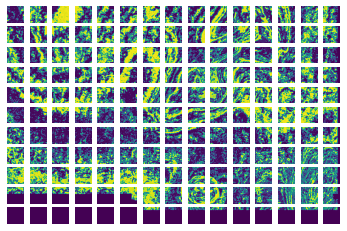

In [12]:
# plot random patches to verify

plot_patched_directions(padded_data, patched_data, patched_grid_sizes, patch_size, directions, output_folder)    
        

In [13]:
### Dimension reduction and visualization with PCA

In [5]:
from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

import numpy as np
import pandas as pd
K.clear_session()
np.random.seed(237)

In [15]:


direction = "inline"
print(patched_data[direction].shape)
data = np.expand_dims(patched_data[direction],axis=-1)
print(data.shape)
length = data.shape[0]//10
val_split = 0.1

# flatten data from (-1, patch_size, patch_size) to  (-1, 4064) 
data = data.reshape(patched_grid_sizes[direction][0], -1)
# find max abs value in data 
max_val = max(abs(np.min(data)),abs(np.max(data))) *0.7 # make sure to clipp sides 
print("abs max ",max_val) # --> outputs 127
# normalize between -1 and 1 
data = data/max_val 
# push first to get values between [0,2] and then devide by 2 to get values between [0,1)]
data = (data + 1) /2
data = np.clip(data, 0, 1)
print("MIN_MAX", np.min(data), np.max(data)) #--> outputs 0 and one 


# reshape to (-1, 64, 64)
data = data.reshape(-1, patch_size, patch_size)

(84480, 64, 64)
(84480, 64, 64, 1)
abs max  88.89999999999999
MIN_MAX 0.0 1.0


In [16]:
print(data.shape)

X_train = data[:1000]#data[:int(length*(1-val_split))]
X_valid = data[:100]#data[int(length*(1-val_split)):]
print(X_train.dtype, np.min(X_train), np.max(X_train))
# Normalize and reshape
X_train = X_train.astype('float32') #/ 255.
X_train = X_train.reshape(-1,patch_size,patch_size,1)

X_valid = X_valid.astype('float32') #/ 255.
X_valid = X_valid.reshape(-1,patch_size,patch_size,1)

print(X_train.shape, X_valid.shape )

(84480, 64, 64)
float64 0.0 1.0
(1000, 64, 64, 1) (100, 64, 64, 1)


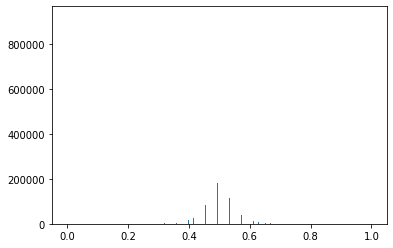

In [17]:
_ = plt.hist(X_train.flatten(), bins='auto')  # arguments are passed to np.histogram
plt.show()

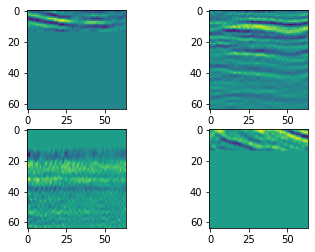

In [18]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[111][:,:,0])

plt.subplot(222)
plt.imshow(X_train[160][:,:,0])

plt.subplot(223)
plt.imshow(X_train[370][:,:,0])

plt.subplot(224)
plt.imshow(X_train[110][:,:,0])
plt.show()

In [19]:
img_shape = (patch_size, patch_size, 1)    # for MNIST
batch_size = 16
latent_dim = 8  # Number of latent dimension parameters
activation = 'relu'

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation=activation)(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation=activation,
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation=activation)(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation=activation)(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation=activation)(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim, name="z_mu")(x)
z_log_sigma = layers.Dense(latent_dim, name="z_log_sigma")(x)



Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
### B. Sampling function

In [21]:
# sampling function 
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [22]:
### C. Decoder network

In [23]:
print(shape_before_flattening[1:])
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation=activation)(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation=activation,
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)
decoder.summary()
# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)


(32, 32, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 65536)             589824    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 1)         289       
Total params: 608,577
Trainable params: 608,577
Non-trainable params: 0
_________________________________________________________________


In [24]:
### D. Loss
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 32, 32, 64)    36928       conv2d_2[0][0]                   
__________________________________________________________________________________________

/home/andykamp/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# for loss diskussion see https://github.com/Lasagne/Recipes/issues/54
# loss nnot changing? https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing
# validating normilization 
print("MIN_MAX_X_train", np.min(X_train), np.max(X_train)) #--> must be [0,1] 
print("MIN_MAX_X_valid", np.min(X_valid), np.max(X_valid)) #--> must be [0,1] 

# start training
history = vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_valid, None))

MIN_MAX_X_train 0.0 1.0
MIN_MAX_X_valid 0.0 1.0
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1000 samples, validate on 100 samples
Epoch 1/100
1000/1000 [==============================] - 3s - loss: 0.6932 - val_loss: 0.6931
Epoch 2/100
 368/1000 [==========>...................] - ETA: 1s - loss: 0.6931

KeyboardInterrupt: 

In [27]:
# store model 
# serialize weights to HDF5
filename =output_folder+"/model_64_64_8x8_1_000.h5"
#vae.save_weights(filename)
#print("Saved model to disk")

vae.load_weights(filename)

#print(history.history.keys())
#print(history.history["loss"])



In [23]:
vae_path = output_folder+"/model_64_64_8x8_1_000.h5"
vae.save(vae_path)

generator_path = output_folder+"/decoder_64_64_8x8_1_000.h5"
decoder.save(generator_path)

In [28]:
# X's and Y's
print("Making sure the data is normalzed", np.min(X_train), np.max(X_train))
X_valid_noTest = X_train[:100]
y_valid_noTest = patched_labels_per_image[direction][:100]
print(X_valid_noTest.shape)


Making sure the data is normalzed 0.0 1.0
(100, 64, 64, 1)


img samples  0.2975253093363329 0.6799775028121485
img samples  0.32544443 0.653647
img samples  0.33086056 0.64943767
(5, 64, 64, 1) (5, 64, 64, 1)


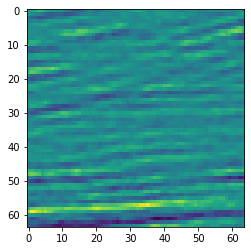

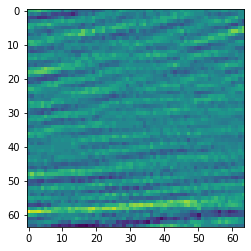

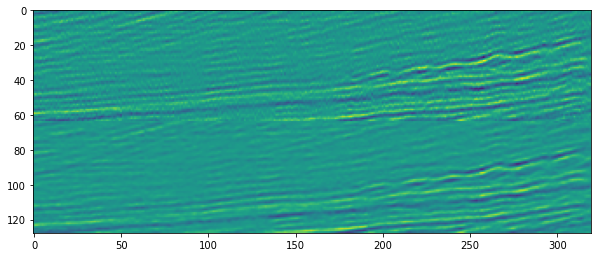

In [29]:
encoder = Model(input_img, z_mu)
vaeeee = Model(input_img, z_decoded)

num_imgs = 5
img_samples = data[50:50+num_imgs].reshape(-1, 64, 64, 1)
print("img samples ", np.min(img_samples), np.max(img_samples))
#run vae through some of them 
reconstructions_vae = vaeeee.predict(img_samples)
reconstructions_enc_dec =decoder.predict(encoder.predict(img_samples))
print("img samples ", np.min(reconstructions_vae), np.max(reconstructions_vae))
print("img samples ", np.min(reconstructions_enc_dec), np.max(reconstructions_enc_dec))

print(reconstructions_vae.shape, reconstructions_enc_dec.shape)

plt.imshow(decoder.predict(encoder.predict(img_samples))[0][:,:,0])
plt.show()
plt.imshow(img_samples[0][:,:,0])
plt.show()

rec_list = [img_samples, reconstructions_enc_dec]
figure = np.zeros((patch_size * len(rec_list), patch_size * num_imgs))
for i, rec_type in enumerate(rec_list):
    for j in range(num_imgs):
        x_decoded = rec_type[j]
        img = rec_type[j][:,:,0]
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()  
#plt.imshow(reconstructions[5].reshape(patch_size, patch_size))
#plt.show()


(41, 64, 64, 1)


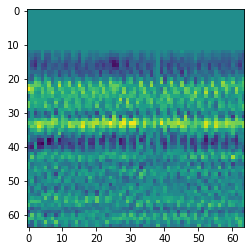

(41, 64, 64, 1)
(41, 8)
(41, 64, 64, 1)


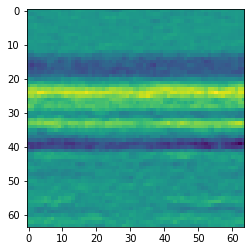

In [30]:


img_samples = X_train[235:276]
print(img_samples.shape)
plt.imshow(img_samples[10][:,:,0])
plt.show()
print(img_samples.shape)
img_encoded = encoder.predict(img_samples)
print(img_encoded.shape)
img_decoded = decoder.predict(img_encoded)
print(img_decoded.shape)
plt.imshow(img_decoded[10][:,:,0])


In [31]:
img_rows, img_cols, img_chns = patch_size, patch_size, 1


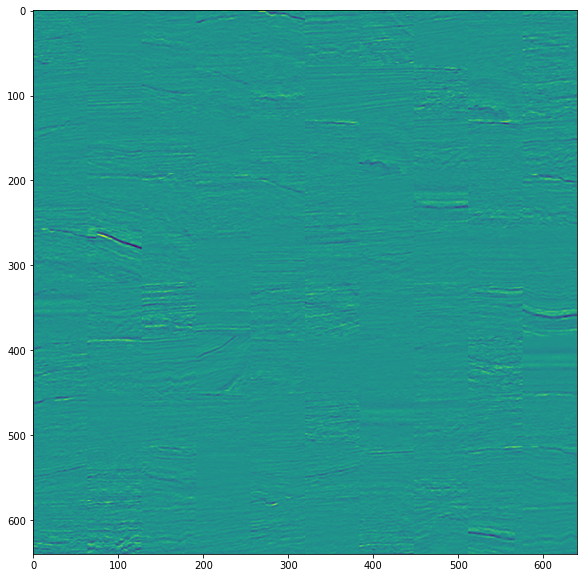

In [35]:
# plot random reconstructions 
n = 10

figure = np.zeros((img_rows * n, img_cols * n))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        #print(z_sample.shape)
        x_recon = decoder.predict(z_sample, batch_size=1)#generator.predict(z_sample, batch_size=1)
        #print(x_recon.shape)
        patch = x_recon.reshape(patch_size, patch_size)
        #print(patch.shape)
        d_x = i * patch_size
        d_y = j * patch_size
        figure[d_x:d_x + patch_size, d_y:d_y + patch_size] = patch

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [36]:
from matplotlib import offsetbox

def plot_components(proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(proj.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i].T, cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
    return ax
            
            


(1000, 64, 64, 1)
found data. loading it to memory
Done trainig pca 
num_labelsss 999 999.0
Plottting:  tline


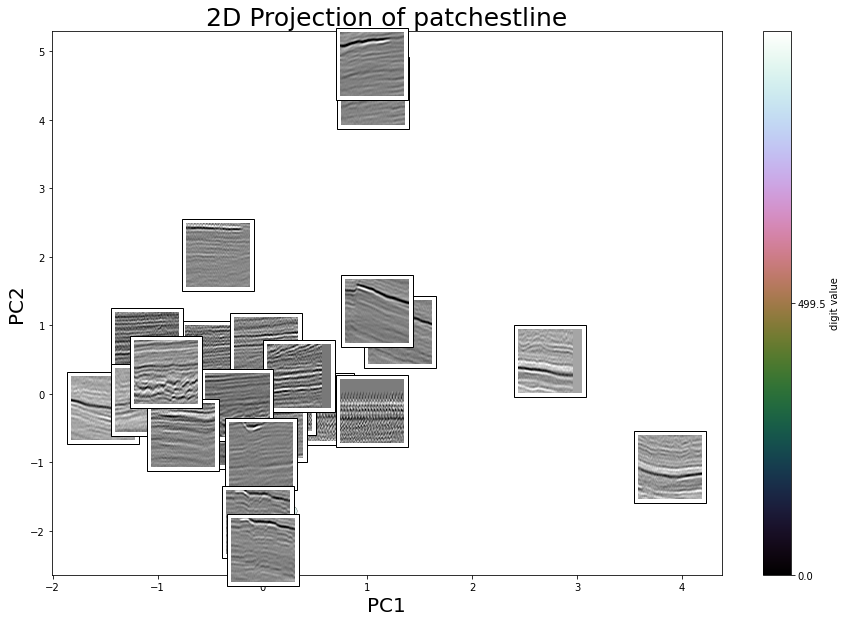

In [37]:
### PLOT ORG IMAHES
from sklearn.decomposition import PCA
print(X_train.shape)
shape = X_train.shape
filename = output_folder + "/pca_embedded_org.npy"
if not os.path.exists(filename):
    print("did not find data.. creating new...")
   
    X_reshape = X_train.reshape((shape[0], -1))
    print(X_reshape.shape)
    n_components = 2
    pca_digits=PCA(n_components)
    pca = pca_digits.fit_transform(X_reshape) 
    print(np.sum(pca_digits.explained_variance_ratio_))
    # store the data 
    np.save(filename, pca)
else:
    print("found data. loading it to memory")
    pca = np.load(filename)
    
print("Done trainig pca ")

# Perform pca  and plot scatterplot of it 
labelss = patched_labels[direction][:shape[0]]
num_labelss = int(np.max(labelss))
print("num_labelsss", num_labelss, labelss[-1])
filename = output_folder + "/pca_" + dir + ".png"
scatter(pca, labelss, num_labelss, dir, show_labels=False, output=filename) 


# Plot acutal images on scatterplot
print("Plottting: ", dir)
images = X_train
plot_components(proj=pca,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])

X_train shape:  (1000, 64, 64, 1)
X_recon shape:  (1000, 8)
found data. loading it to memory
Done trainig pca 
num_labelsss 999 999.0
Plottting:  tline
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 8)
z_sample_decoded (1, 64, 64, 1)


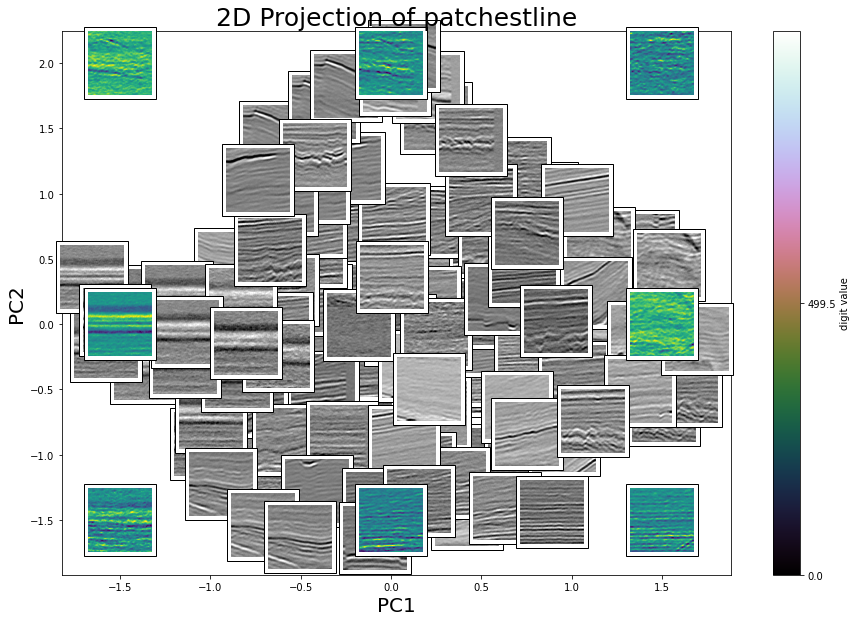

In [53]:
### PLOT ENCODING OF ORGINAL IMAGES ALONG WITH RECONSTRUCTION 
# Here we hope for more meaningful variance 
from sklearn.decomposition import PCA
shape = X_train.shape
print( "X_train shape: ", shape)

X_recon =encoder.predict(X_train)
print( "X_recon shape: ",X_recon.shape)

filename = output_folder + "/pca_embedded.npy"
pca_model_filename = output_folder + "/pca_model.npy"

if not os.path.exists(filename):
    print("did not find data.. creating new...")
   
    X_reshape = X_recon.reshape((shape[0], -1))
    print(X_reshape.shape)
    n_components = 2
    pca_model=PCA(n_components)
    pca = pca_model.fit_transform(X_reshape) 
    print(np.sum(pca_model.explained_variance_ratio_))
    # store the data 
    np.save(filename, pca)
    print('Dumping pca model to: %s' % (pca_model_filename)) 
    joblib.dump(pca_model, pca_model_filename)
else:
    print("found data. loading it to memory")
    pca = np.load(filename)
    pca_model = joblib.load(pca_model_filename)

    
print("Done trainig pca ")

# Perform pca  and plot scatterplot of it 
labelss = patched_labels[direction][:shape[0]]
num_labelss = int(np.max(labelss))
print("num_labelsss", num_labelss, labelss[-1])
filename = output_folder + "/pca.png"
scatter(pca, labelss, num_labelss, dir, show_labels=False, output=filename) 


# Plot acutal images on scatterplot
print("Plottting: ", dir)
#random_indexes = np.random.choice(shape[0], 100)
#print("random_indexes", random_indexes)
images = decoder.predict(X_recon)
ax = plot_components(proj=pca,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])
# now i can chooose a point in the 2d space, inverse pca transform it and decode it to se how it looks betweeen training data

# show a random generated image
def add_image(coord):
    z_sample = pca_model.inverse_transform(coord).reshape(1, -1)
    print("z_sample", z_sample.shape)
    z_sample_decoded = decoder.predict(z_sample)
    print("z_sample_decoded", z_sample_decoded.shape)
    img_decoded = z_sample_decoded.reshape(patch_size, patch_size)
    #plt.imshow(img_decoded)
    #plt.show()
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img_decoded), coord)
    ax.add_artist(imagebox)


coord = np.asarray([-1.5,-1.5])
add_image(coord)

coord = np.asarray([-1.5,0])
add_image(coord)


coord = np.asarray([-1.5,2])
add_image(coord)


coord = np.asarray([1.5,-1.5])
add_image(coord)

coord = np.asarray([1.5,0])
add_image(coord)

coord = np.asarray([1.5,2])
add_image(coord)

coord = np.asarray([0,2])
add_image(coord)

coord = np.asarray([0, -1.5])
add_image(coord)





In [19]:
# Display a 2D manifold of the digits
n = 10  # figure with 20x20 digits
figure = np.zeros((patch_size * n, patch_size * n))

# 1. create grid form training pca space 
print("input shape", pca.shape)
#x_min, x_max = pca[:, 0].min() - 1, pca[:, 0].max() + 1
#y_min, y_max = pca[:, 1].min() - 1,pca[:, 1].max() + 1
#xx, yy = np.meshgrid(np.linspace(x_min, x_max, n),
#                    np.linspace(y_min, y_max, n))
xxx = np.flip(norm.ppf(np.linspace(0.05, 0.95, n)))
yyy = norm.ppf(np.linspace(0.05, 0.95, n))
print(xxx[:5], yyy[:5])
grid_inp = np.empty([n*n, 2])
ii=0
for i, yi in enumerate(xxx):
    for j, xi in enumerate(yyy):
        grid_inp[ii] = np.asarray([xi, yi])
        ii+=1
print("grid_inp", grid_inp[:10], grid_inp[-10:])

#print(x_min, y_max, y_min, y_max, xx.shape, yy.shape)
# convert to actual coordinate format 
#grid_inp = np.c_[xx.ravel(), yy.ravel()]   
#print(grid_inp.shape, grid_inp[0:10])

# 2. inverce pca it to get correct latent dims 
latent_grid_inp = pca_model.inverse_transform(grid_inp)
print(latent_grid_inp.shape)

# 3. decode each latent vector
latent_grid_out = decoder.predict(latent_grid_inp)
print(latent_grid_out.shape)
# 4. plot it in grid
indx = 0
for i, yi in enumerate(xx):
    for j, xi in enumerate(yy):
        z_sample = np.squeeze(latent_grid_out[indx])
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = z_sample
        indx+=1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

NameError: name 'patch_size' is not defined

In [2]:
# Now we have a vae, we can calculate the latent space riemann 

from scripts.riemannian.riemannian_latent_space import RiemannianMetric, RiemannianTree
import tensorflow as tf
import keras 
generator_path = output_folder+"/decoder_64_64_8x8_1_000.h5"
decoder = keras.models.load_model(generator_path)

filename = output_folder + "/pca_embedded.npy"
pca_model_filename = output_folder + "/pca_model.npy"

if not os.path.exists(filename):
    print("did not find data.. creating new...")
   
    X_reshape = X_recon.reshape((shape[0], -1))
    print(X_reshape.shape)
    n_components = 2
    pca_model=PCA(n_components)
    pca = pca_model.fit_transform(X_reshape) 
    print(np.sum(pca_model.explained_variance_ratio_))
    # store the data 
    np.save(filename, pca)
    print('Dumping pca model to: %s' % (pca_model_filename)) 
    joblib.dump(pca_model, pca_model_filename)
else:
    print("found data. loading it to memory")
    pca = np.load(filename)
    pca_model = joblib.load(pca_model_filename)
    
latent_dim = 8
batch_size = 16

Using TensorFlow backend.







found data. loading it to memory


/home/andykamp/envs/master/lib/python3.7/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


z_sampel (1, 8)
x_decoded.shape (1, 64, 64, 1)
Tensor("input_2:0", shape=(?, 8), dtype=float32) Tensor("conv2d_5/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("strided_slice:0", shape=(?,), dtype=float32) Tensor("conv2d_5/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)
num_layer (?, 8) (?, ?, 1)

Done

nklnlnnkl Tensor("conv2d_5/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32) Tensor("input_2:0", shape=(?, 8), dtype=float32)
dsfsdsdfds Tensor("strided_slice_3:0", shape=(?, ?, 1), dtype=float32) Tensor("input_2:0", shape=(?, 8), dtype=float32)
Output None
doneee


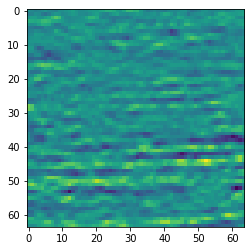

In [3]:
# before dooing this we need to change the riemann.py in the scrips tag.
# there we have hardcoded 28 when it is rally 64

z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
print("z_sampel", z_sample.shape)
x_decoded = decoder.predict(z_sample, batch_size=batch_size)
print("x_decoded.shape", x_decoded.shape)
plt.imshow(np.squeeze(x_decoded))
#decoder.summary()
model_input = decoder.inputs[0]
model_output = decoder.outputs[0]
print(model_input, model_output)
print(model_input[:,0], model_output)
print("num_layer",model_input[:,:].shape, model_output[:,0].shape )
#output_dim = model_output.shape[1]
#print("output_dim", model_output.shape[1])
#J=[tf.gradients(model_output[:, _], model_input)[0] for _ in range(64)]
#print(J)
#J = tf.stack(J, axis=1)  # batch x output x latent
print("")
print("Done")
print("")
session = tf.Session()
session.run(tf.global_variables_initializer())
rmetric = RiemannianMetric(x=model_output, z=model_input, session=session)
rmetric.create_tf_graph()
print("doneee") 




(1000, 64, 64, 1) (1000, 8) (1000, 2)
[-0.4960702   0.043786    0.6194415   0.41740146 -0.11104685  0.17423892
  0.07205079 -0.10816053]
x_decoded.shape (1000, 64, 64, 1)
donecalc magnitude  [2.64692938e-11 1.46180672e-11 2.11782415e-11 1.64496472e-11
 1.67799108e-11 2.03421082e-11 2.39502619e-11 2.89918697e-11
 3.36134558e-11 2.11499845e-11 2.23913475e-11 2.19256991e-11
 2.36312185e-11 1.95039852e-11 2.34190271e-11 2.05104926e-11
 2.04197371e-11 1.55224340e-11 2.76175263e-11 2.26069007e-11
 1.87792802e-11 1.54987065e-11 1.79743234e-11 2.18619758e-11
 1.87526852e-11 2.48113561e-11 1.52395457e-11 2.16727383e-11
 1.79949042e-11 2.48059611e-11 1.82153945e-11 3.11375092e-11
 1.52547263e-11 1.86769749e-11 2.59766965e-11 2.87337359e-11
 1.70533917e-11 2.66772004e-11 1.95734505e-11 1.42523389e-11
 1.91104806e-11 1.46720622e-11 1.29150969e-11 1.27548232e-11
 1.98905267e-11 1.73725010e-11 2.60335885e-11 1.75156677e-11
 1.76710348e-11 2.15841251e-11 2.25885404e-11 3.12725609e-11
 2.25292042e-11 

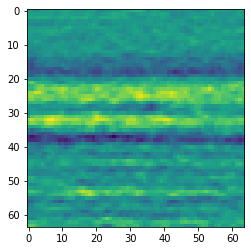

<Figure size 432x288 with 0 Axes>

In [79]:
print(X_train.shape, X_recon.shape, pca.shape)
print(X_recon[0])
num = 100
x_decoded = decoder.predict(X_recon, batch_size=batch_size)
print("x_decoded.shape", x_decoded.shape)
plt.imshow(np.squeeze(x_decoded[10]))

mf = session.run(rmetric.MF, {rmetric.z: X_recon[:num]})
print("donecalc magnitude ", mf)
plt.figure()
print(pca[:num,0])
#plt.scatter(pca[:num,0], pca[:num,1], c=mf)
#plt.show()


input shape (1000, 2)
[1.64485363 1.20404696 0.92082298 0.69714143 0.50396537] [-1.64485363 -1.20404696 -0.92082298 -0.69714143 -0.50396537]
grid_inp [[-1.64485363e+00  1.64485363e+00]
 [-1.20404696e+00  1.64485363e+00]
 [-9.20822976e-01  1.64485363e+00]
 [-6.97141435e-01  1.64485363e+00]
 [-5.03965367e-01  1.64485363e+00]
 [-3.28072108e-01  1.64485363e+00]
 [-1.61844167e-01  1.64485363e+00]
 [-1.39145821e-16  1.64485363e+00]
 [ 1.61844167e-01  1.64485363e+00]
 [ 3.28072108e-01  1.64485363e+00]] [[-3.28072108e-01 -1.64485363e+00]
 [-1.61844167e-01 -1.64485363e+00]
 [-1.39145821e-16 -1.64485363e+00]
 [ 1.61844167e-01 -1.64485363e+00]
 [ 3.28072108e-01 -1.64485363e+00]
 [ 5.03965367e-01 -1.64485363e+00]
 [ 6.97141435e-01 -1.64485363e+00]
 [ 9.20822976e-01 -1.64485363e+00]
 [ 1.20404696e+00 -1.64485363e+00]
 [ 1.64485363e+00 -1.64485363e+00]]
(225, 8)
mf grid (225,)
3.5212543e-12 1.2495556e-11
0.0 1.0


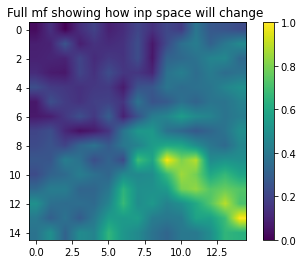

In [18]:
# Now we want to plot the riemann metric to display the distorion when goin from Z --> X
# This is more complicated as the datapoints are not in 2d when we encode. 
# The goal is to look how much the datapoint in z actually diverge by looking at how much they change from Z --> X
# We can rom this assume that high divergence in this process contribute to more sditance among the points. 
# By plotting it we can infer geometry to the latent space. 

# If this was 2d we could easily calc the metric for each gridpoint in the 2d plane. 
# But when our latet space is in more (e.g 16) dimentions we cannot pick such a grid
# But, we can project the 16 dimensjons on to the 2d GRID BY EITHER pca, T_SNE(not good for distances) or UMAP. 
# Here, seeing these are symetrical (meaning map from x->z and z-> x will give same x ) we assume that 
# we can 
    # 1. choose a. grid from the training pca (where the datapoints so far have landed and most new will), 
    # 2. Calc the inverse PCA for all these, therby finding the 16 dim vector corresponding to this "cell"
    # 3. calc riemann magnitude over this, and seeing we know the posision in 2d for the 16d vecotr, we can plot it in the 2d PCA space. 
    # 4. plot it in a 2d map with the scatterplots 

# 1. create grid form training pca space 
print("input shape", pca.shape)
#h = 0.4  # step size in the mesh
#x_min, x_max = pca[:, 0].min() - 1, pca[:, 0].max() + 1
#y_min, y_max = pca[:, 1].min() - 1,pca[:, 1].max() + 1
#xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                    np.arange(y_min, y_max, h))
#print(x_min, y_max, y_min, y_max, xx.shape, yy.shape)
# convert to actual coordinate format 
#grid_inp = np.c_[xx.ravel(), yy.ravel()]   
#print(grid_inp.shape)
n = 15 
xxx = np.flip(norm.ppf(np.linspace(0.05, 0.95, n)))
yyy = norm.ppf(np.linspace(0.05, 0.95, n))
print(xxx[:5], yyy[:5])
grid_inp = np.empty([n*n, 2])
ii=0
for i, yi in enumerate(xxx):
    for j, xi in enumerate(yyy):
        grid_inp[ii] = np.asarray([xi, yi])
        ii+=1
print("grid_inp", grid_inp[:10], grid_inp[-10:])


# 2. inverce pca it to get correct latent dims 
latent_grid_inp = pca_model.inverse_transform(grid_inp)
print(latent_grid_inp.shape)

# 3. calc riemann magnitude for each latend vector 
mf = session.run(rmetric.MF, {rmetric.z: latent_grid_inp})
print("mf grid", mf.shape)



# 4. plot it in a scatterplot 
# Put the result into a color plot
Z = mf.reshape(n, n)
print(Z.min(), Z.max())
def normalizeData(data):
      return (data - np.min(data)) / (np.max(data) - np.min(data))
Z = normalizeData(Z)
print(Z.min(), Z.max())

plt.figure()
plt.imshow(Z, interpolation="bilinear")
#plt.pcolormesh(xx, yy, Z, cmap="brg")

#plot actuals
plt.title("Full mf showing how inp space will change ")
plt.colorbar()
plt.show()


